<a href="https://colab.research.google.com/github/shubha07m/vision-language-modeling/blob/main/guided_3Dmetal_printing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating all masks for metal strips with SAM

In [ ]:
# Installing libraries
!pip install torch torchvision segment-anything opencv-python-headless

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Importing library and downloading models

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.measure import regionprops
from scipy.spatial.distance import cdist
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!mkdir sam_images
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-s80jsz3s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-s80jsz3s
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-07-15 22:47:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   234MB/s    in 14s     

2024-07

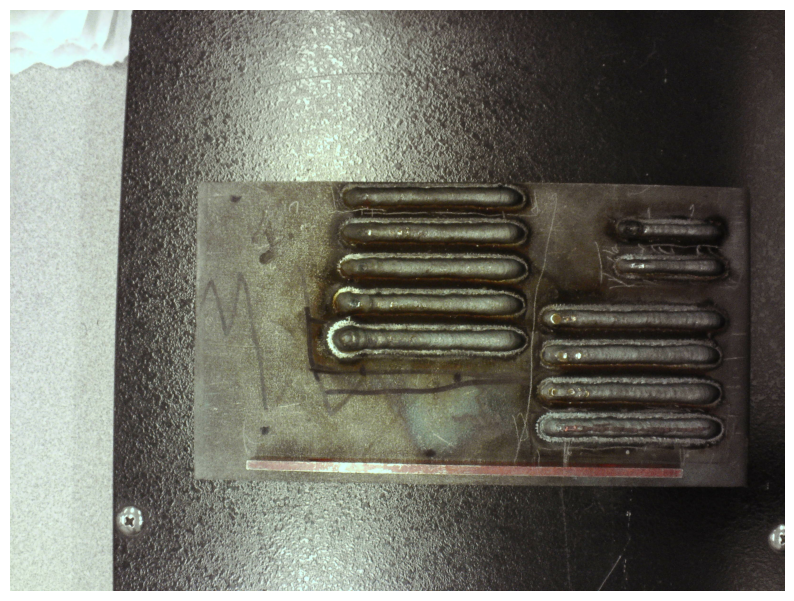

In [ ]:
# Loading the image and show

image = cv2.imread('sam_images/practice.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Initializing model checkpoints

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# Generating mask using SAM

masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

29
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
# Function for showing all segmentation mask on an image

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

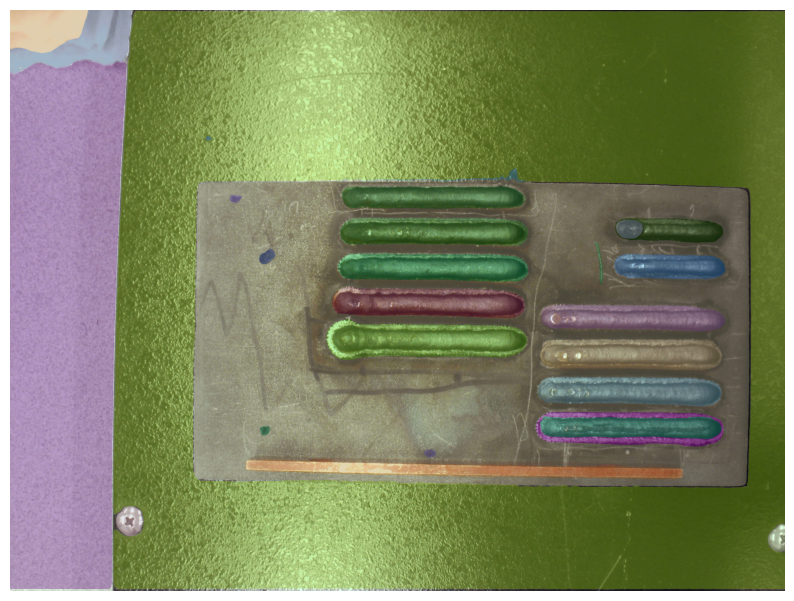

In [ ]:
# Showing all the masks on an image

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Filtering specific mask for metal strips

In [ ]:
# Filtering the masks based on shape and filtering outliters

def show_strip_masks(anns, image, min_aspect_ratio=3, max_aspect_ratio=20, min_solidity=0.8, max_strips=20, area_threshold=2.5):
    if len(anns) == 0:
        return

    # First, filter annotations based on shape
    strip_anns = [ann for ann in anns if is_strip_like(ann['segmentation'],
                                                       min_aspect_ratio,
                                                       max_aspect_ratio,
                                                       min_solidity)]

    if len(strip_anns) == 0:
        print("No strip-like masks found")
        return

    # Calculate median area of strip-like masks
    areas = [ann['area'] for ann in strip_anns]
    median_area = np.median(areas)

    # Filter out masks that are significantly larger than the median
    strip_anns = [ann for ann in strip_anns if ann['area'] <= area_threshold * median_area]

    # Sort by area and take the top max_strips
    strip_anns = sorted(strip_anns, key=(lambda x: x['area']), reverse=True)[:max_strips]

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)

    for i, ann in enumerate(strip_anns):
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        masked = np.zeros((m.shape[0], m.shape[1], 4))
        masked[m] = color_mask
        ax.imshow(masked)

        # Add a label to each strip
        y, x = np.where(m)
        ax.text(x.mean(), y.mean(), f"{i+1}", color='white', fontweight='bold',
                ha='center', va='center')

    ax.set_title(f"Showing {len(strip_anns)} strip-like masks")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return strip_anns

In [ ]:
# Function to decide if a mask is strip like or not

def is_strip_like(mask, min_aspect_ratio=3, max_aspect_ratio=20, min_solidity=0.8):
    props = regionprops(mask.astype(int))[0]

    aspect_ratio = max(props.major_axis_length / props.minor_axis_length,
                       props.minor_axis_length / props.major_axis_length)

    return (min_aspect_ratio <= aspect_ratio <= max_aspect_ratio) and (props.solidity >= min_solidity)

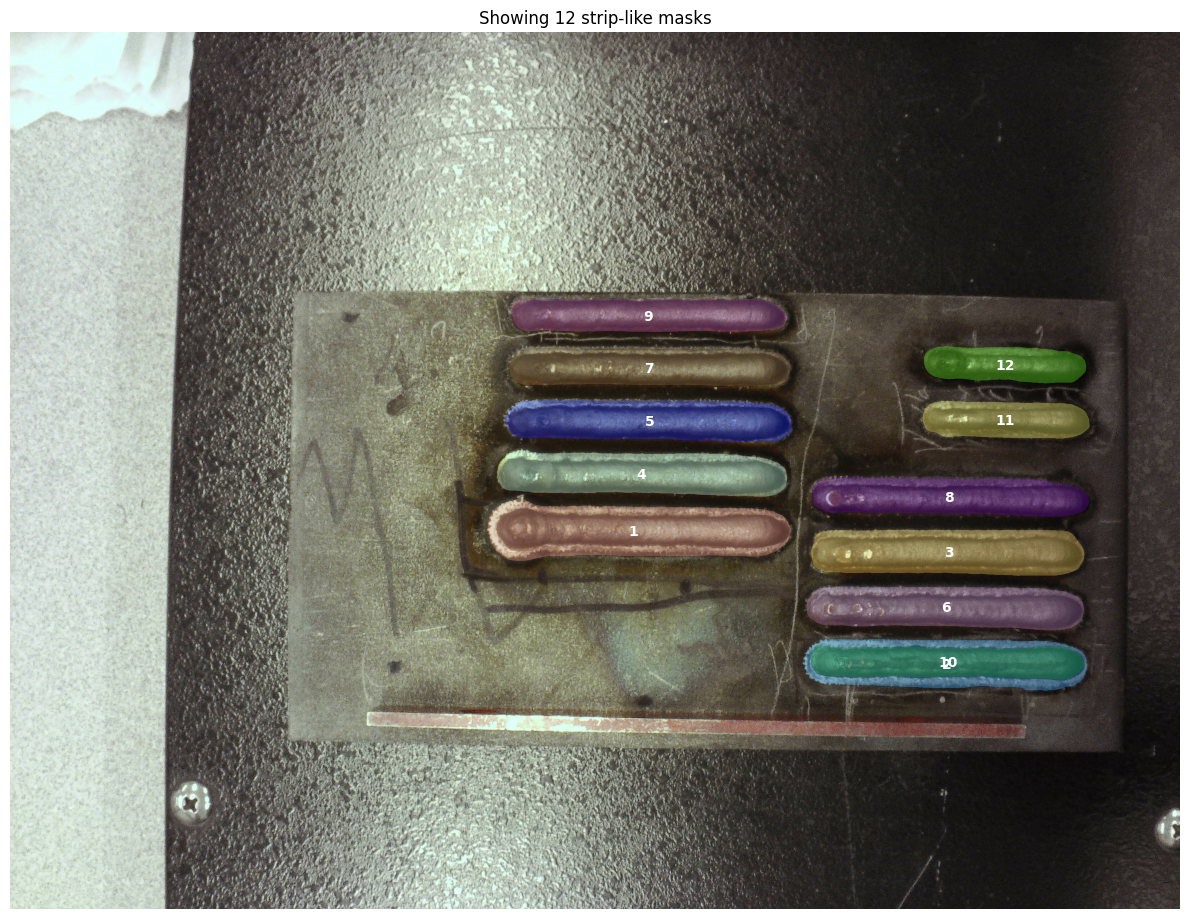

In [ ]:
# Showing the selected strips

strip_masks = show_strip_masks(masks, image, min_aspect_ratio=3, max_aspect_ratio=20, min_solidity=0.8, max_strips=20, area_threshold=2.5)

In [ ]:
# Function to measure strip gaps

def measure_strip_gaps(strip_masks, downsample_factor=4):
    gaps = []
    n_masks = len(strip_masks)

    for i in range(n_masks):
        for j in range(i+1, n_masks):
            mask1 = strip_masks[i]['segmentation']
            mask2 = strip_masks[j]['segmentation']

            # Downsample masks
            mask1_down = mask1[::downsample_factor, ::downsample_factor]
            mask2_down = mask2[::downsample_factor, ::downsample_factor]

            # Get edge points
            y1, x1 = np.where(mask1_down)
            y2, x2 = np.where(mask2_down)

            points1 = np.column_stack((x1, y1))
            points2 = np.column_stack((x2, y2))

            # Calculate distances
            distances = cdist(points1, points2)

            # Calculate min, max, and mean gaps
            min_distance = np.min(distances) * downsample_factor
            max_distance = np.max(distances) * downsample_factor
            mean_distance = np.mean(distances) * downsample_factor

            gaps.append({
                'mask1': i,
                'mask2': j,
                'min_gap': min_distance,
                'max_gap': max_distance,
                'mean_gap': mean_distance
            })

    return gaps

In [ ]:
# analyze the strip gaps statistics

def analyze_strip_gaps(strip_masks, downsample_factor=4):
    gaps = measure_strip_gaps(strip_masks, downsample_factor)

    # Calculate statistics
    min_gaps = [gap['min_gap'] for gap in gaps]
    max_gaps = [gap['max_gap'] for gap in gaps]
    mean_gaps = [gap['mean_gap'] for gap in gaps]

    print(f"Gap Analysis for {len(strip_masks)} strips:")
    print(f"Minimum gaps - Mean: {np.mean(min_gaps):.2f}, Median: {np.median(min_gaps):.2f}, Min: {np.min(min_gaps):.2f}, Max: {np.max(min_gaps):.2f}")
    print(f"Maximum gaps - Mean: {np.mean(max_gaps):.2f}, Median: {np.median(max_gaps):.2f}, Min: {np.min(max_gaps):.2f}, Max: {np.max(max_gaps):.2f}")
    print(f"Mean gaps    - Mean: {np.mean(mean_gaps):.2f}, Median: {np.median(mean_gaps):.2f}, Min: {np.min(mean_gaps):.2f}, Max: {np.max(mean_gaps):.2f}")

    # Visualize gap distributions
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].hist(min_gaps, bins=20, edgecolor='black')
    axs[0].set_title('Distribution of Minimum Gaps')
    axs[0].set_xlabel('Gap Size (pixels)')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(max_gaps, bins=20, edgecolor='black')
    axs[1].set_title('Distribution of Maximum Gaps')
    axs[1].set_xlabel('Gap Size (pixels)')

    axs[2].hist(mean_gaps, bins=20, edgecolor='black')
    axs[2].set_title('Distribution of Mean Gaps')
    axs[2].set_xlabel('Gap Size (pixels)')

    plt.tight_layout()
    plt.show()

    return gaps, np.mean(min_gaps), np.mean(max_gaps), np.mean(mean_gaps)

Gap Analysis for 12 strips:
Minimum gaps - Mean: 345.80, Median: 356.00, Min: 0.00, Max: 890.57
Maximum gaps - Mean: 1323.23, Median: 1617.82, Min: 500.02, Max: 1901.60
Mean gaps    - Mean: 768.64, Median: 883.62, Min: 225.39, Max: 1301.84


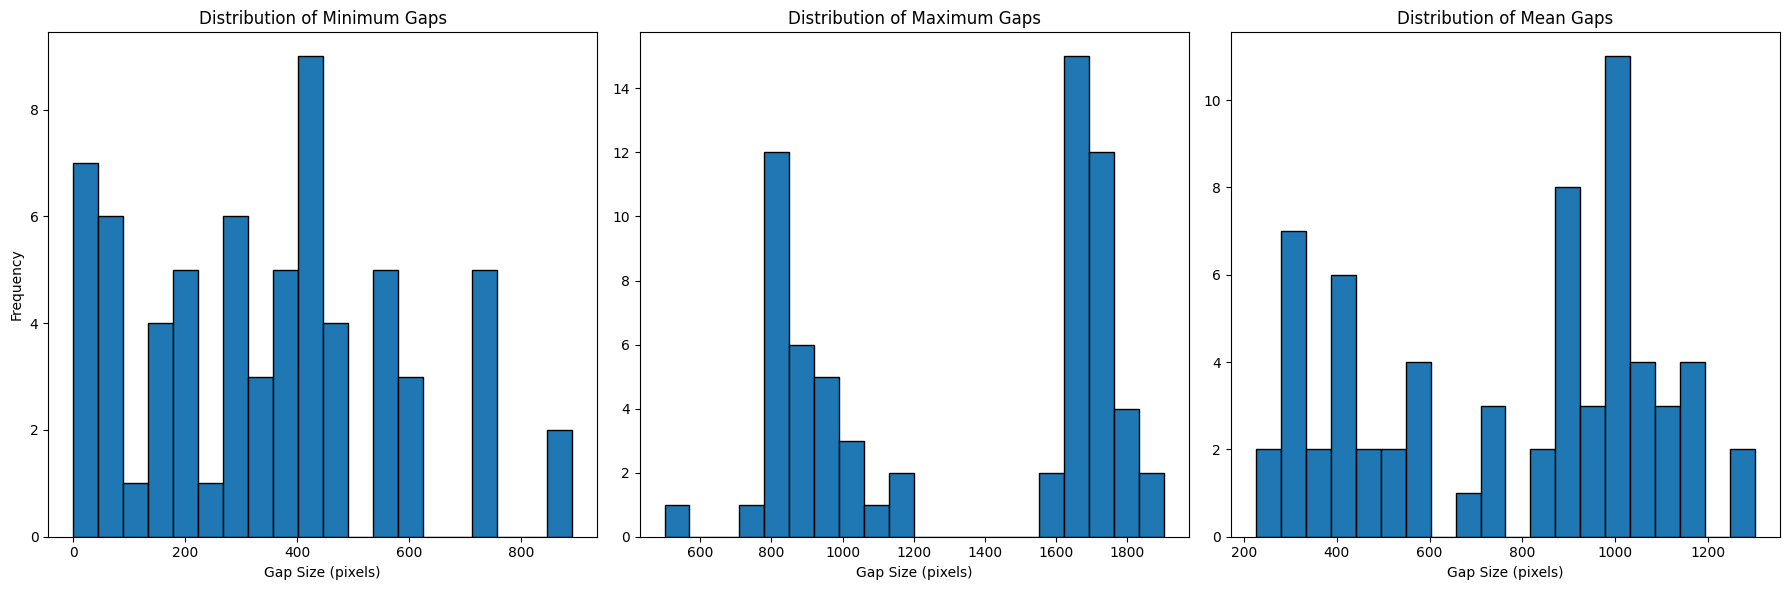

In [ ]:
# Showing the gap statistics

gaps, avg_min_gap, avg_max_gap, avg_mean_gap = analyze_strip_gaps(strip_masks)

In [ ]:
# Function to guide the 3D metal printing process

def guide_printing_process(avg_min_gap, avg_max_gap, avg_mean_gap, min_threshold=5, max_threshold=50, mean_threshold=20):
    print("\nPrinting Process Guidance:")
    if avg_min_gap < min_threshold:
        print(f"Warning: Average minimum gap ({avg_min_gap:.2f}) is below threshold. Risk of strip overlap. Increase separation.")
    if avg_max_gap > max_threshold:
        print(f"Caution: Average maximum gap ({avg_max_gap:.2f}) is above threshold. Some areas may have excessive spacing.")
    if avg_mean_gap < mean_threshold:
        print(f"Suggestion: Average mean gap ({avg_mean_gap:.2f}) is below ideal. Consider slightly increasing overall separation.")
    elif avg_mean_gap > mean_threshold * 1.5:
        print(f"Suggestion: Average mean gap ({avg_mean_gap:.2f}) is larger than ideal. Consider slightly decreasing overall separation.")
    else:
        print(f"Current average gap measurements (Min: {avg_min_gap:.2f}, Max: {avg_max_gap:.2f}, Mean: {avg_mean_gap:.2f}) are within acceptable range.")

In [ ]:
# Printing Instructions to guide printing
guide_printing_process(avg_min_gap, avg_max_gap, avg_mean_gap)


Printing Process Guidance:
Caution: Average maximum gap (1323.23) is above threshold. Some areas may have excessive spacing.
Suggestion: Average mean gap (768.64) is larger than ideal. Consider slightly decreasing overall separation.
